In [1]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('sample-orders.csv', encoding = 'unicode_escape')

In [3]:
df.head()

,order_date,order_id,customer,grand_total
0,9/7/11,CA-2011-100006,Dennis Kane,378
1,7/8/11,CA-2011-100090,Ed Braxton,699
2,3/14/11,CA-2011-100293,Neil Franzsisch,91
3,1/29/11,CA-2011-100328,Jasper Cacioppo,4
4,4/8/11,CA-2011-100363,Jim Mitchum,21


### RFM Analysis

- Recency - how recent a customer has bought
- frequency - how frequently a customer buys product
- Monetry - how much money a customer spends

In [4]:
df.describe()

,grand_total
count,5009.000000
mean,458.626672
std,954.729307
min,1.000000
25%,38.000000
50%,152.000000
75%,512.000000
max,23661.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 4 columns):
order_date     5009 non-null object
order_id       5009 non-null object
customer       5009 non-null object
grand_total    5009 non-null int64
dtypes: int64(1), object(3)
memory usage: 156.6+ KB


In [6]:
type(df['order_date'][0])

str

In [7]:
df['order_date'] = pd.to_datetime(df['order_date'])

In [8]:
# identify the last date in the data. This will become as the baseline date 
latest_date = max(df['order_date'])

In [9]:
df['rec'] = latest_date - df['order_date'] 
df['rec'] = df['rec'].dt.days
df.head()

,order_date,order_id,customer,grand_total,rec
0,2011-09-07,CA-2011-100006,Dennis Kane,378,1211
1,2011-07-08,CA-2011-100090,Ed Braxton,699,1272
2,2011-03-14,CA-2011-100293,Neil Franzsisch,91,1388
3,2011-01-29,CA-2011-100328,Jasper Cacioppo,4,1432
4,2011-04-08,CA-2011-100363,Jim Mitchum,21,1363


In [10]:
r = df.groupby(['customer'])['rec'].min()

In [11]:
# frequecy
f = df.groupby(['customer'])['order_id'].count()

In [12]:
# Monetry
m = df.groupby(['customer'])['grand_total'].sum()

In [13]:
rfm = pd.DataFrame({'Recency': r,'Frequency':f, 'Monetory':m })
rfm['R_score'] = None
rfm['F_score'] = None
rfm['M_score'] = None
rfm.head()

,Recency,Frequency,Monetory,R_score,F_score,M_score
customer,,,,,,
Aaron Bergman,415,3,887,None,None,None
Aaron Hawkins,12,7,1744,None,None,None
Aaron Smayling,88,7,3050,None,None,None
Adam Bellavance,54,8,7756,None,None,None
Adam Hart,34,10,3249,None,None,None


In [14]:
# create scores for r,f,m

### Identify RFM quartiles

In [15]:
rfm_quartiles = rfm[['Recency','Frequency','Monetory']].describe().loc[['25%', '50%','75%']]
rfm_quartiles

,Recency,Frequency,Monetory
25%,30.0,5.0,1145.0
50%,75.0,6.0,2257.0
75%,183.0,8.0,3784.0


In [16]:
rfm['R_score'][rfm['Recency'] >= rfm_quartiles['Recency'].loc['75%']] = 1
rfm['R_score'][(rfm['Recency'] >= rfm_quartiles['Recency'].loc['50%']) & (rfm['Recency'] < rfm_quartiles['Recency'].loc['75%'])] = 2
rfm['R_score'][(rfm['Recency'] >= rfm_quartiles['Recency'].loc['25%']) & (rfm['Recency'] < rfm_quartiles['Recency'].loc['50%'])] = 3
rfm['R_score'][rfm['Recency'] <= rfm_quartiles['Recency'].loc['25%'] ] = 4

rfm['F_score'][rfm['Frequency'] >= rfm_quartiles['Frequency'].loc['75%']] = 4
rfm['F_score'][(rfm['Frequency'] >= rfm_quartiles['Frequency'].loc['50%']) & (rfm['Frequency'] < rfm_quartiles['Frequency'].loc['75%'])] = 3
rfm['F_score'][(rfm['Frequency'] >= rfm_quartiles['Frequency'].loc['25%']) & (rfm['Frequency'] < rfm_quartiles['Frequency'].loc['50%'])] = 2
rfm['F_score'][rfm['Frequency'] <= rfm_quartiles['Frequency'].loc['25%']] = 1

rfm['M_score'][rfm['Monetory'] >= rfm_quartiles['Monetory'].loc['75%']] = 4
rfm['M_score'][(rfm['Monetory'] >= rfm_quartiles['Monetory'].loc['50%']) & (rfm['Monetory'] < rfm_quartiles['Monetory'].loc['75%'])] = 3
rfm['M_score'][(rfm['Monetory'] >= rfm_quartiles['Monetory'].loc['25%']) & (rfm['Monetory'] < rfm_quartiles['Monetory'].loc['50%'])] = 2
rfm['M_score'][rfm['Monetory'] <= rfm_quartiles['Monetory'].loc['25%']] = 1


In [17]:
rfm.head()

,Recency,Frequency,Monetory,R_score,F_score,M_score
customer,,,,,,
Aaron Bergman,415,3,887,1,1,1
Aaron Hawkins,12,7,1744,4,3,2
Aaron Smayling,88,7,3050,2,3,3
Adam Bellavance,54,8,7756,3,4,4
Adam Hart,34,10,3249,3,4,3


In [18]:
rfm['RFM'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

In [19]:
rfm.head()

,Recency,Frequency,Monetory,R_score,F_score,M_score,RFM
customer,,,,,,,
Aaron Bergman,415,3,887,1,1,1,111
Aaron Hawkins,12,7,1744,4,3,2,432
Aaron Smayling,88,7,3050,2,3,3,233
Adam Bellavance,54,8,7756,3,4,4,344
Adam Hart,34,10,3249,3,4,3,343


In [20]:
#Customer Segmentation
rfm['Customer Segment'] = None
champions = ['444']
loyal_customers = ['334', '342', '343', '344', '433', '434', '443']
potential_loyalist = ['332','333','341','412','413','414','431','432','441','442','421','422','423','424']
recent_customers = ['411']
promising = ['311', '312', '313', '331']
needing_attention = ['212','213','214','231','232','233','241','314','321','322','323','324']
about_to_sleep = ['211']
at_risk = ['112','113','114','131','132','133','142','124','123','122','121','224','223','222','221']
cant_lose = ['134','143','144','234','242','243','244']
hibernating = ['141']
lost = ['111']
rfm['Customer Segment'][rfm['RFM'].isin(champions)] = 'Champions'
rfm['Customer Segment'][rfm['RFM'].isin(loyal_customers)] = 'Loyal Customers'
rfm['Customer Segment'][rfm['RFM'].isin(potential_loyalist)] = 'Potential Loyalist'
rfm['Customer Segment'][rfm['RFM'].isin(recent_customers)] = 'Recent customers'
rfm['Customer Segment'][rfm['RFM'].isin(promising)] = 'Promising'
rfm['Customer Segment'][rfm['RFM'].isin(needing_attention)] = 'Customer Needing Attention'
rfm['Customer Segment'][rfm['RFM'].isin(about_to_sleep)] = 'About to Sleep'
rfm['Customer Segment'][rfm['RFM'].isin(at_risk)] = 'At Risk'
rfm['Customer Segment'][rfm['RFM'].isin(cant_lose)] = 'Can’t Lose Them'
rfm['Customer Segment'][rfm['RFM'].isin(hibernating)] = 'Hibernating'
rfm['Customer Segment'][rfm['RFM'].isin(lost)] = 'Lost'

### Identify segment of where we company is At Risk of losing them 

In [21]:
rfm[rfm['Customer Segment'] == 'At Risk']

,Recency,Frequency,Monetory,R_score,F_score,M_score,RFM,Customer Segment
customer,,,,,,,,
Alan Shonely,192,7,585,1,3,1,131,At Risk
Alejandro Grove,278,5,2584,1,1,3,113,At Risk
Alex Avila,184,5,5564,1,1,4,114,At Risk
Amy Hunt,230,5,2496,1,1,3,113,At Risk
Andrew Allen,259,4,1791,1,1,2,112,At Risk
Andy Gerbode,845,4,1456,1,1,2,112,At Risk
Becky Martin,307,4,11790,1,1,4,114,At Risk
Ben Wallace,203,6,1739,1,3,2,132,At Risk
Benjamin Venier,334,5,1522,1,1,2,112,At Risk


### Identify segment of who are the Most Loyal Customers

In [22]:
rfm[rfm['Customer Segment'] == 'Champions']

,Recency,Frequency,Monetory,R_score,F_score,M_score,RFM,Customer Segment
customer,,,,,,,,
Alan Dominguez,29,8,6107,4,4,4,444,Champions
Alan Hwang,6,9,4806,4,4,4,444,Champions
Annie Thurman,13,10,3831,4,4,4,444,Champions
Arianne Irving,13,10,4376,4,4,4,444,Champions
Ben Ferrer,16,11,5907,4,4,4,444,Champions
Brenda Bowman,28,9,6766,4,4,4,444,Champions
Brosina Hoffman,23,8,6255,4,4,4,444,Champions
Chris Cortes,20,12,3913,4,4,4,444,Champions
Dan Reichenbach,3,9,6528,4,4,4,444,Champions


In [30]:
rfm['Customer Segment'].value_counts()

Loyal Customers               148
Customer Needing Attention    109
At Risk                       105
Potential Loyalist            101
Can’t Lose Them                97
Lost                           67
Promising                      63
Champions                      39
About to Sleep                 32
Recent customers               31
Hibernating                     1
Name: Customer Segment, dtype: int64

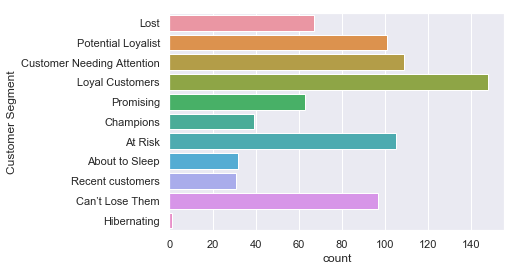

In [29]:
sns.set(style="darkgrid")
ax = sns.countplot(y="Customer Segment", data=rfm)
